# Predict Customer Churn - Improve ML models performance

This project is to build a predictive machine learning model using the customer churn data available at Kaggle website. <br>
Part 3 will look at training various classification models and hyperparameter tuning selected candidate models.<br>

The classification algorithms to be considered:
1. K nearest neighbours (KNN)
2. logistic regression
3. Decision Trees 
4. SVM linear
5. SVM RBF
6. Neural network (multi-layer perceptron)
7. Guassian process
8. Naive-Bayes (GaussianNB)
9. Quadratic Discriminant Analysis

## Prepare data
### Global functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from time import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import customfunctions

In [3]:
# Calculate roc_auc score
def calculate_roc_auc_score(model,X, y): 
    pred_proba = model.predict_proba(X)
    roc_auc = roc_auc_score(y, pred_proba[:,1])
    return roc_auc

### Read in data

In [4]:
## Read in data
df0 = pd.read_csv('./data/visathon_train_data.csv')#,index=customer_id)
print('Shape: {}'.format(df0.shape))
df0.sample(5)

Shape: (17654, 20)


,customer_id,vintage,age,gender,dependents,occupation,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
3134,4295.0,1439.0,40.0,Female,0.0,Accountant,Medium,728.0,40.0,2174.85,2246.28,2117.95,2916.78,0.21,9.19,71.64,0.21,2177.31,2085.94,Yes
13531,18539.0,1810.0,32.0,Female,0.0,Engineer,Medium,443.0,230.0,2956.71,2956.71,2956.71,2933.14,0.23,0.23,0.23,0.23,2956.71,2956.71,Yes
9746,13374.0,1462.0,51.0,Female,0.0,Engineer,Medium,2068.0,200.0,1537.86,1531.25,1809.04,8937.77,0.44,0.44,0.44,0.44,1535.53,1531.25,Yes
3195,4379.0,501.0,48.0,Male,2.0,Engineer,Medium,1487.0,44.0,371.93,9831.46,9763.02,15823.57,0.04,2857.19,159.57,3016.71,9359.94,9805.03,No
12113,16591.0,2740.0,35.0,Male,0.0,Accountant,Low,148.0,87.0,10744.03,11449.50,11199.84,10653.70,0.33,0.33,705.80,0.33,10792.69,11449.50,Yes


### Split data

In [5]:
target = 'churn'
X = df0.drop(target,axis=1).copy()
y = df0[target].copy()

In [6]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.25, random_state=10086)
print('X_train shape: {}\nX_valid shape: {}\ny_train shape: {}\ny_valid shape: {}'.format( X_train.shape, X_valid.shape, y_train.shape, y_valid.shape))

X_train shape: (13240, 19)
X_valid shape: (4414, 19)
y_train shape: (13240,)
y_valid shape: (4414,)


## Load data pipelines

In [7]:
pipeline_data = joblib.load('pipeline_data.joblib')

In [8]:
X_train_transformed = pipeline_data.transform(X_train)
X_valid_transformed = pipeline_data.transform(X_valid)
y_train_transformed = y_train.map({"Yes":1,"No":0})
y_valid_transformed = y_valid.map({"Yes":1,"No":0})
X_train_transformed.shape, X_valid_transformed.shape

((13240, 47), (4414, 47))

Once the data sets are transformed, the next step is to use the transformed data to train models.

## Train classification models
This section we will look at screen various classification algorithms to select a few promising candidates for further tuning.

This model set includes 9 scikit-learn classification algorithms (excluding those from ensemble family). The classification algorithms from the ensumble family will be discussed in ***Model set 2*** section.

### 1. Select candidate models

In [23]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# Model seclection
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint, uniform

# Model evaluation
from sklearn.metrics import roc_auc_score, roc_curve

from time import time

In [8]:
names = [
    "K Nearest Neighbors",
    "Logistic Regression",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Neural Net",
    "Naive Bayes",
    "Quadratic Discriminant Analysis",
    "Gaussian Process",
]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(max_iter=500, n_jobs=-1, random_state=15611),
    SVC(kernel="linear", C=0.025, probability=True, random_state=15611),
    SVC(gamma=2, C=1, probability=True, random_state=15611),
    DecisionTreeClassifier(max_depth=5, random_state=15611),
    MLPClassifier(alpha=1, max_iter=1000, random_state=15611),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=15611),
]

In [9]:
# iterate over classifiers

score = {}
model = {}
for name, clf in zip(names, classifiers):
    start = time()   
    print("Fitting: {}".format(name))
    clf.fit(X_train_transformed, y_train)
    # calculate roc_auc score
    score[name] = calculate_roc_auc_score(clf,X_valid_transformed, y_valid)
    model[name] = clf
    print("{} has a roc_auc score: {}".format(name, roc_auc))
    print(f'Time elapsed: {round((time()-start)/60,2)} minutes for model "{name}"\n')
    joblib.dump(clf, 'screening - ' + name +'.joblib')


Fitting: K Nearest Neighbors
K Nearest Neighbors has a roc_auc score: 0.6954400705782202
Time elapsed: 0.05 minutes for model "K Nearest Neighbors"

Fitting: Logistic Regression
Logistic Regression has a roc_auc score: 0.8214096142524876
Time elapsed: 0.06 minutes for model "Logistic Regression"

Fitting: Linear SVM
Linear SVM has a roc_auc score: 0.8108315337684235
Time elapsed: 0.35 minutes for model "Linear SVM"

Fitting: RBF SVM
RBF SVM has a roc_auc score: 0.6933260185970016
Time elapsed: 2.46 minutes for model "RBF SVM"

Fitting: Decision Tree
Decision Tree has a roc_auc score: 0.7884593561234959
Time elapsed: 0.0 minutes for model "Decision Tree"

Fitting: Neural Net
Neural Net has a roc_auc score: 0.8317108129973347
Time elapsed: 0.1 minutes for model "Neural Net"

Fitting: Naive Bayes
Naive Bayes has a roc_auc score: 0.7626442938234406
Time elapsed: 0.0 minutes for model "Naive Bayes"

Fitting: Quadratic Discriminant Analysis
Quadratic Discriminant Analysis has a roc_auc score

C:\Users\tessi\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Gaussian Process has a roc_auc score: 0.8367389454466432
Time elapsed: 156.25 minutes for model "Gaussian Process"



In [17]:
screening_results_nonens = joblib.load('sccreening - results non-ensemble.joblib')
# score = screening_results_nonens['score']
# model = screening_results_nonens['model']
# joblib.dump(screening_results_nonens, 'sccreening - results non-ensemble.joblib')

['sccreening - results non-ensemble.joblib']

In [14]:
# Ensemble classifiers
names = [
    "Random Forest",
    "Extra Trees",
    "ADAboosting",
    "Gradient Boosting",
    "XGBoost",
]

classifiers = [
    RandomForestClassifier(max_depth=2, random_state=15611,n_jobs=-1),
    ExtraTreesClassifier(random_state=15611,n_jobs=-1),
    AdaBoostClassifier(random_state=15611),
    GradientBoostingClassifier(random_state=15611),
    XGBClassifier(random_state=15611)
]

In [16]:
# iterate over classifiers

for name, clf in zip(names, classifiers):
    start = time()   
    print("Fitting: {}".format(name))
    clf.fit(X_train_transformed, y_train_transformed)
    roc_auc = calculate_roc_auc_score(clf, X_valid_transformed, y_valid_transformed)
    score[name] = roc_auc
    model[name] = clf
    print("{} has a roc_auc score: {}".format(name, roc_auc))
    print(f'Time elapsed: {round((time()-start)/60,2)} minutes for model "{name}"\n')
    joblib.dump(clf, 'screening - ' + name +'.joblib')


Fitting: Random Forest
Random Forest has a roc_auc score: 0.800539653159031
Time elapsed: 0.01 minutes for model "Random Forest"

Fitting: Extra Trees
Extra Trees has a roc_auc score: 0.8201183869109483
Time elapsed: 0.01 minutes for model "Extra Trees"

Fitting: ADAboosting
ADAboosting has a roc_auc score: 0.8189050325585637
Time elapsed: 0.03 minutes for model "ADAboosting"

Fitting: Gradient Boosting
Gradient Boosting has a roc_auc score: 0.8319529181238734
Time elapsed: 0.15 minutes for model "Gradient Boosting"

Fitting: XGBoost
XGBoost has a roc_auc score: 0.8151662971027588
Time elapsed: 0.04 minutes for model "XGBoost"



In [18]:
screening_results = {'score':score,'model': model}
joblib.dump(screening_results, 'sccreening - results all models.joblib')

['sccreening - results all models.joblib']

In [10]:
# screening_results = joblib.load('sccreening - results all models.joblib')

In [20]:
# Model for candidate of the best model
print('roc_auc score = {} for model {}'.format(round(screening_results['score']['Gaussian Process'],4),screening_results['model']['Gaussian Process']))

roc_auc score = 0.8367 for model GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1), random_state=15611)


The screening of the models indicated that 5 models, i.e., 3 non-ensemble models ***LogigsticRegression, Neural Network (MLPClassifier), and GaussianProcessClassifier)***, and 2 ensemble models ***ExtraTrees (XTr) and Gradient Boosting (GBC), have ***over 0.82*** roc_auc scores (0.821, 0.832, and 0.837, 0.8201, and 0.8320, respectively). <br>
Since the GaussianProcessClassifier is already hyperparameter optimized for the kernel and none of the other parameters are to be tuned, and more importantly, it is too computationally intensive to complete tuning using the resources available, we will use the result from this stage as the best estimator. <br>

Therefore, the next step is to further tune the remaining 4 models to select the best models and parameters for this dataset.

### 2. Tune Hyperparameters of candiate models
We will tune the hyparameters using ***RandomSearchCV*** from scikit learn's model_selection module. Parameter distribution will be using the ***loguniform and randint*** distribution from scipy's stats module. Thes distributions generate a continuous range of floates and integers, repectively, for the hyperparameters of interest. We will use two sets of parameter spaces to tune the selected candidate models. <br>

The first set of hyperparameter space will tune 4 and 5 hyperparameters for LF and MLP, respectively and randomly sample 50 hyperparameter combinations. The second set of hyperparameter space will tune more hyperparameters (5 for LF and 10 for MLP and randomly sample 100 hyperparameter combinations. In addition, for LF, two versions of penalty and solver settings will also be tuned. This allows for us to examine if a finer tuning and more iteration will have more chance to get a better final model. <br>

For ensemble models, we will use the same hyperparameter distribution space as in the baseline models for model tuning.

#### **Hyperparameter tuning - non-ensemble setting 1**
#### *1) Random Search CV*

In [33]:
## create a pipeline
pipe_clf = Pipeline([('classifier',LogisticRegression())])

## Create dictionary with candidate learning algorithms and their hyperparameters
param_space =  [{"classifier": [LogisticRegression(random_state=15611, max_iter=200)],
                 'classifier__penalty': ['l1','l2'],
                 'classifier__solver': ['liblinear'],
                 'classifier__C': loguniform(0.0001, 100),
                },
                {"classifier": [LogisticRegression(random_state=15611, max_iter=200)],
                 'classifier__penalty': ['l2'],
                 'classifier__solver': ['lbfgs','sag'],
                 'classifier__C': loguniform(0.0001, 100),
                },
                {"classifier": [MLPClassifier(random_state=15611)],
                 'classifier__activation':['tanh','relu'],
                 'classifier__learning_rate': ['constant','invscaling'],
                 'classifier__solver': ['adam','sgd'],
                 'classifier__alpha':loguniform(0.0001,1),
                },]

# Parameter tuning
start = time()
clf_randsearchcv_v1 = RandomizedSearchCV(estimator = pipe_clf, 
                                      param_distributions=param_space, 
                                      scoring='roc_auc',
                                      n_iter=50,
                                      cv=5, 
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state = 15661
                                      )
clf_randsearchcv_v1.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-start)/60,2)} minutes')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.3min finished


Time elapsed: 4.5 minutes


In [21]:
joblib.dump(clf_randsearchcv_v1,'clf_randsearchcv_v1.joblib')
# clf_randsearchcv_v1 = joblib.load('clf_randsearchcv_v1.joblib')

#### *2) Best estimator*

In [45]:
print(f'Best SearchCV_v1 score: {clf_randsearchcv_v1.best_score_}')
clf_randsearchcv_v1.best_params_

Best SearchCV_v1 score: 0.8365526545730623


{'classifier': MLPClassifier(alpha=0.47857874420504615, learning_rate='invscaling',
               random_state=15611),
 'classifier__activation': 'relu',
 'classifier__alpha': 0.47857874420504615,
 'classifier__learning_rate': 'invscaling',
 'classifier__solver': 'adam'}

In [46]:
# number of layers in the neural network:
print('Number of layers in the neural network = {}'.format(clf_randsearchcv_v1.best_estimator_['classifier'].n_layers_))

Number of layers in the neural network = 3


In [47]:
print(f"Mean cv scores - Highest: {clf_randsearchcv_v1.cv_results_['mean_test_score'].max()} \
from param combination {np.where(clf_randsearchcv_v1.cv_results_['mean_test_score'] == clf_randsearchcv_v1.cv_results_['mean_test_score'].max())[0]}")

print('Mean cv scores:')
clf_randsearchcv_v1.cv_results_['mean_test_score']

Mean cv scores - Highest: 0.8365526545730623 from param combination [20]
Mean cv scores:


array([0.7143584 , 0.8212159 , 0.80464247, 0.79563221, 0.5       ,
       0.83617181, 0.79426399, 0.82179706, 0.81658174, 0.79291375,
       0.82426393, 0.83367244, 0.80863407, 0.82190925, 0.79588528,
       0.83437785, 0.82088893, 0.82137082, 0.82084798, 0.80953672,
       0.83655265, 0.80896515, 0.81812586, 0.82162234, 0.83385271,
       0.77605702, 0.81443284, 0.77905083, 0.82121608, 0.80546593,
       0.82189366, 0.82180561, 0.78671436, 0.83365347, 0.81534916,
       0.60245676, 0.82145197, 0.82111212, 0.82168169, 0.81461085,
       0.60245801, 0.77103347, 0.82115119, 0.82190766, 0.79608996,
       0.81519294, 0.815888  , 0.71436019, 0.71436197, 0.82105215])

#### *3) Best prediction accuracy*

In [49]:
# Best prediction score
clf_nn_v1_roc_auc = calculate_roc_auc_score(clf_randsearchcv_v1.best_estimator_,X_valid_transformed, y_valid)
clf_nn_v1_roc_auc

0.8370823852962486

#### **Hyperparameter tuning - non-ensemble setting 2**
#### *1) Randomized Search CV*

In [24]:
## create a pipeline
pipe_clf = Pipeline([('classifier',LogisticRegression())])

## Create dictionary with candidate learning algorithms and their hyperparameters
param_space =  [{"classifier": [LogisticRegression(random_state=15611)],
                 'classifier__penalty': ['l1','l2'],
                 'classifier__solver': ['liblinear'],
                 'classifier__C': loguniform(0.0001, 100),
                 'classifier__max_iter': randint(200, 600),
                },
                {"classifier": [LogisticRegression(random_state=15611)],
                 'classifier__penalty': ['l2'],
                 'classifier__solver': ['lbfgs','sag'],
                 'classifier__C': loguniform(0.0001, 100),
                 'classifier__max_iter': randint(200, 600),
                },
                {"classifier": [MLPClassifier(random_state=15611)],
                 'classifier__activation':['tanh','relu'],
                 'classifier__hidden_layer_sizes': randint(5,100),
                 'classifier__learning_rate': ['constant','invscaling'],
                 'classifier__max_iter': randint(200,600),
                 'classifier__solver': ['adam','sgd'],
                 'classifier__alpha':loguniform(0.0001,1),
                },]

# Parameter tuning
start = time()
clf_randsearchcv_v2 = RandomizedSearchCV(estimator = pipe_clf, 
                                      param_distributions=param_space, 
                                      scoring='roc_auc',
                                      n_iter=100,
                                      cv=5, 
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state = 15661
                                      )
clf_randsearchcv_v2.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-start)/60,2)} minutes')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.6min finished


Time elapsed: 11.72 minutes


In [41]:
joblib.dump(clf_randsearchcv_v2,'clf_randsearchcv_v2.joblib')
# load the save search result
# clf_randsearchcv_v2 = joblib.load('clf_randsearchcv_v2.joblib')

#### *2) Best estimator*

In [51]:
print(f'Best roc_auc Score: {round(clf_randsearchcv_v2.best_score_,4)}')
print('Best model and parameters:')
clf_randsearchcv_v2.best_params_

Best roc_auc Score: 0.839
Best model and parameters:


{'classifier': MLPClassifier(activation='tanh', alpha=0.6818883687798777,
               hidden_layer_sizes=23, max_iter=381, random_state=15611),
 'classifier__activation': 'tanh',
 'classifier__alpha': 0.6818883687798777,
 'classifier__hidden_layer_sizes': 23,
 'classifier__learning_rate': 'constant',
 'classifier__max_iter': 381,
 'classifier__solver': 'adam'}

In [52]:
# number of layers in the neural network:
print('Number of layers in the neural network = {}'.format(clf_randsearchcv_v2.best_estimator_['classifier'].n_layers_))

Number of layers in the neural network = 3


In [54]:
print(f"Mean cv scores - Highest: {clf_randsearchcv_v2.cv_results_['mean_test_score'].max()} \
from param combination {np.where(clf_randsearchcv_v2.cv_results_['mean_test_score'] == clf_randsearchcv_v2.cv_results_['mean_test_score'].max())[0]}")

print('Mean cv scores - each parameter and model combination:')
clf_randsearchcv_v2.cv_results_['mean_test_score']

Mean cv scores - Highest: 0.8390006793252989 from param combination [7]
Mean cv scores - each parameter and model combination:


array([0.83216388, 0.82103508, 0.79641244, 0.75461824, 0.81938759,
       0.82865189, 0.83335945, 0.83900068, 0.82193232, 0.82140794,
       0.79039227, 0.74323042, 0.82195663, 0.81539166, 0.82144958,
       0.82188846, 0.83655056, 0.78641216, 0.82173645, 0.78080493,
       0.78902971, 0.81265627, 0.83306915, 0.81441836, 0.82185715,
       0.78266958, 0.82195199, 0.78997597, 0.82183448, 0.80149711,
       0.75668774, 0.83676797, 0.78798366, 0.82109846, 0.5       ,
       0.81201199, 0.82145376, 0.79101191, 0.82035662, 0.68181791,
       0.81594161, 0.82159623, 0.82130352, 0.82181011, 0.82167796,
       0.50664998, 0.82189511, 0.82136413, 0.8170432 , 0.82056363,
       0.82074023, 0.80182747, 0.77796511, 0.57142085, 0.81262428,
       0.82182886, 0.82106252, 0.7920473 , 0.83476188, 0.75115288,
       0.75668721, 0.80735567, 0.62850006, 0.61894621, 0.8216624 ,
       0.82187902, 0.82183115, 0.82137593, 0.83305111, 0.8054598 ,
       0.83145474, 0.82188433, 0.79059453, 0.81845724, 0.82022

#### *3) Best prediction accuracy*

In [73]:
# Best prediction score
clf_nn_v2_roc_auc =  calculate_roc_auc_score(clf_randsearchcv_v2.best_estimator_,X_valid_transformed, y_valid)
print(f'Prediction score with the best model: {round(clf_nn_v2_roc_auc,4)}')

Prediction score with the best model: 0.8363


##### **Hyperparameter tuning - ensemble models**
##### *1) Randomized Search CV*

In [28]:
## create a pipeline
pipe_clf2 = Pipeline([('classifier',AdaBoostClassifier())])

## Create dictionary with candidate learning algorithms and their hyperparameters
param_space2 =  [{"classifier": [AdaBoostClassifier(random_state=15611)],
                 'classifier__n_estimators': randint(5,100),
                 'classifier__learning_rate': loguniform(0.001, 100),
                 'classifier__algorithm': ['SAMME', 'SAMME.R']
                },
                {"classifier": [GradientBoostingClassifier(random_state=15611)],
                 'classifier__loss': ['deviance', 'exponential'],
                 'classifier__n_estimators': randint(5,100),
                 'classifier__learning_rate': loguniform(0.0001, 100),
                 'classifier__max_depth': randint(1,20),
                 'classifier__max_features': randint(5, X_train.shape[1]+1),
                 'classifier__min_samples_split': randint(5, 100),
                },
                {"classifier": [XGBClassifier(random_state=15611,objective='binary:logistic')],
                 'classifier__eta':loguniform(0.0001, 100),
                 'classifier__gamma': loguniform(0.0001, 100),
                 'classifier__max_depth': randint(1,20),
                 'classifier__min_child_weight': loguniform(0.01, 100),
                 'classifier__max_delta_step':randint(1,10),
                 'classifier__subsample':uniform(0,1)
                },]

# Parameter tuning
start = time()
clf_ensemble = RandomizedSearchCV(estimator = pipe_clf2, 
                                      param_distributions=param_space2, 
                                      scoring='roc_auc',
                                      n_iter=50,
                                      cv=5, 
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state = 15611
                                      )
clf_ensemble.fit(X_train_transformed, y_train_transformed)
print(f'Time elapsed: {round((time()-start)/60,2)} minutes')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.9min finished


Time elapsed: 3.98 minutes


In [43]:
joblib.dump(clf_ensemble,'clf_ensemble_randsearchcv.joblib')
# load the save search result
# clf_ensemble = joblib.load('clf_ensemble_randsearchcv.joblib')

['clf_ensemble_randsearchcv.joblib']

##### *2) Best estimator*

In [44]:
print(f'Best roc_auc Score: {round(clf_ensemble.best_score_,4)}')
print('Best model and parameters:')
clf_ensemble.best_params_

Best roc_auc Score: 0.8388
Best model and parameters:


{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eta=0.11473698305487026,
               eval_metric=None, gamma=0.0033678015840455837, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=2, max_depth=9,
               max_leaves=None, min_child_weight=76.22036610408519, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=15611,
               reg_alpha=None, ...),
 'classifier__eta': 0.11473698305487026,
 'classifier__gamma': 0.0033678015840455837,
 'classifier__max_delta_step': 2,
 'classifier__max_depth': 9,
 'classifier__min_child_weight': 76.

In [45]:
print(f"Mean cv scores - Highest: {clf_ensemble.cv_results_['mean_test_score'].max()} \
from param combination {np.where(clf_ensemble.cv_results_['mean_test_score'] == clf_ensemble.cv_results_['mean_test_score'].max())[0]}")

print('Mean cv scores - each parameter and model combination:')
clf_ensemble.cv_results_['mean_test_score']

Mean cv scores - Highest: nan from param combination []
Mean cv scores - each parameter and model combination:


array([0.82598994, 0.8277616 , 0.70535448, 0.73123156, 0.83673967,
       0.83548499, 0.80698667, 0.83703376, 0.79842761, 0.82863358,
       0.66968515, 0.76088134, 0.60892535, 0.6285698 , 0.83777094,
       0.58024403, 0.81678971, 0.82995218, 0.82919403, 0.82364735,
       0.75146923,        nan, 0.65148427, 0.82137618, 0.51500028,
       0.73120583, 0.82004079, 0.39705494, 0.69416703, 0.63413626,
       0.83701793, 0.75947024, 0.83193084, 0.72046716, 0.80930355,
       0.74533516, 0.83496543, 0.81025907, 0.83280392, 0.82065317,
       0.64559098, 0.8279354 , 0.65634404, 0.78193386, 0.76876341,
       0.83880616,        nan, 0.68142986, 0.81321882, 0.83688048])

**Ranking of the models by CV scores**

In [46]:
best2= pd.DataFrame({'score': list(clf_ensemble.cv_results_['mean_test_score'])})
best2['model'] = [param['classifier'] for param in clf_ensemble.cv_results_['params']]
best2 = best2.sort_values('score',ascending=False)
best2['rank'] = np.arange(1,best2.shape[0]+1)
print(best2.head())
print(best2.tail())

       score                                              model  rank
45  0.838806  XGBClassifier(base_score=None, booster=None, c...     1
14  0.837771     GradientBoostingClassifier(random_state=15611)     2
7   0.837034  XGBClassifier(base_score=None, booster=None, c...     3
30  0.837018     GradientBoostingClassifier(random_state=15611)     4
49  0.836880     GradientBoostingClassifier(random_state=15611)     5
       score                                              model  rank
15  0.580244     GradientBoostingClassifier(random_state=15611)    46
24  0.515000     GradientBoostingClassifier(random_state=15611)    47
27  0.397055  XGBClassifier(base_score=None, booster=None, c...    48
21       NaN             AdaBoostClassifier(random_state=15611)    49
46       NaN             AdaBoostClassifier(random_state=15611)    50


In [47]:
print('These models were not able to produce scores:')
print('Model 21:', clf_ensemble.cv_results_['params'][21])
print('Model 46:', clf_ensemble.cv_results_['params'][46])

These models were not able to produce scores:
Model 21: {'classifier': AdaBoostClassifier(random_state=15611), 'classifier__algorithm': 'SAMME', 'classifier__learning_rate': 29.505981997046952, 'classifier__n_estimators': 37}
Model 46: {'classifier': AdaBoostClassifier(random_state=15611), 'classifier__algorithm': 'SAMME', 'classifier__learning_rate': 5.568762198594363, 'classifier__n_estimators': 70}


In [48]:
print('The best gbc model (the 2nd best):')
clf_ensemble.cv_results_['params'][14]

The best gbc model (the 2nd best):


{'classifier': GradientBoostingClassifier(random_state=15611),
 'classifier__learning_rate': 0.00010027932482822924,
 'classifier__loss': 'deviance',
 'classifier__max_depth': 15,
 'classifier__max_features': 5,
 'classifier__min_samples_split': 23,
 'classifier__n_estimators': 87}

In [49]:
# Best GBC model (the third best model)
gbc = GradientBoostingClassifier(learning_rate=0.0001002793248282292,loss='deviance',
                    max_features=5, max_depth=15,
                    min_samples_split=23,
                    n_estimators=87,
                    random_state=15611)
gbc.fit(X_train_transformed,y_train_transformed);

##### *3) Prediction accuracy*

In [50]:
# Prediction score of the best two models, MLP and logistic regression
print('roc_auc score of the best XGBC model: {}'.format(round(calculate_roc_auc_score(clf_ensemble.best_estimator_,X_valid_transformed, y_valid_transformed),4)))
print('roc_auc score of the best GBC model: {}'.format(round(calculate_roc_auc_score(gbc,X_valid_transformed, y_valid_transformed),4)))

roc_auc score of the best XGBC model: 0.8369
roc_auc score of the best GBC model: 0.8284


## Evaluate best models

### Learning curve
This section will plot the learning curve of the best models identified in the previous section from Model sets 1 and 2. <br>
For model set 1, plotting learning curve of Gaussian process model took forever return the plot - as it is shown in the model screening section that it took 156 minutes, compared to a few seconds for the other models (except for SVM RBF kernel 2.6 minutes). Therefore, this section will ommit learning curve of this model. 

In [51]:
# download from GitHub repository
import requests
# Save plot_learning_curve as file to colab working directory
# Get the "Raw" version of the code from GitHub
url = 'https://raw.githubusercontent.com/TessieTong/ds4ml/main/plot_learning_curve.py'
r = requests.get(url)

# Write to Colab working directory 
with open('plot_learning_curve.py', 'w') as f:
    f.write(r.text)

# import
from plot_learning_curve import plot_learning_curve

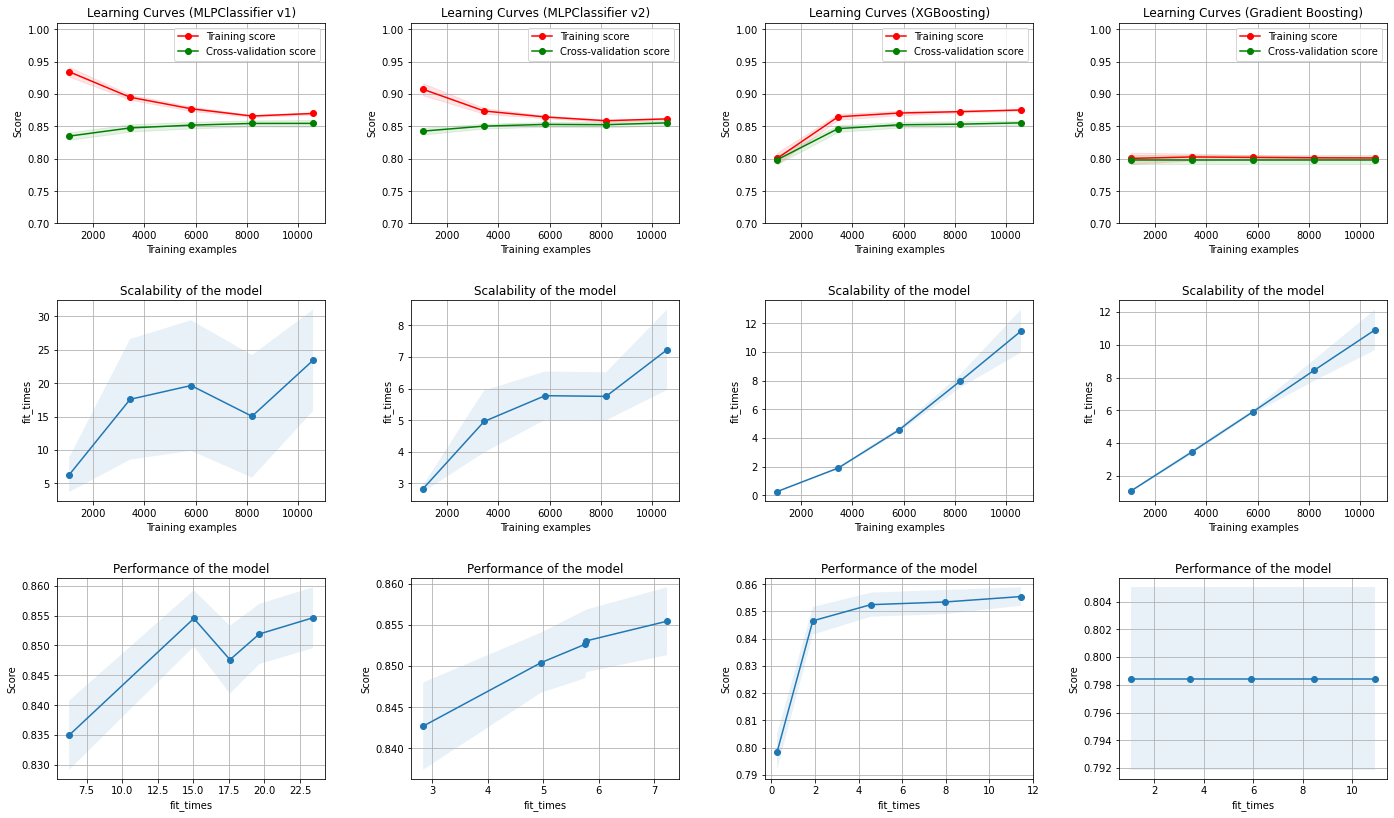

In [42]:
# Plot learning curves of the 4 best ensemble classifiers
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
nrows=3
ncols=4
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
# Cross validation with 10 iterations
# score curves, each time with 20% data randomly selected as a validation set.
# Here only the training set is used.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=15611)

title = r"Learning Curves (MLPClassifier v1)"
plot_learning_curve(clf_randsearchcv_v1.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (MLPClassifier v2)"
plot_learning_curve(clf_randsearchcv_v2.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (XGBoosting)"
plot_learning_curve(clf_ensemble.best_estimator_,
    title, X_train_transformed, y_train_transformed, 
    axes=axes[:, 2], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (Gradient Boosting)"
plot_learning_curve(gbc,
    title, X_train_transformed, y_train_transformed, 
    axes=axes[:, 3], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)


plt.tight_layout(pad=3.0)
plt.show();

Both MLP models are somewhat underfitting, judging by learning curves. Both Training score decreases relatively rapidly while cross-validation score climbes slowly, with increasing the number of examples. The best model from the hyperparameter setting 1 seems to have a better scalability, but take more fit-times to get the highest score. <br>

Due to the nature of RandomizedSearchCV algorithm, although there is no garantee that more hyperparameters in the distribution space or more sample combinations will produce the best models, certainly the chances of finding best models will be higher.

### Prediction accuracy

In [54]:
# Best prediction score
print('Prediction and CV scores of the 5 best models:\n')
print('Model \t\t\tprediction score\tCV score')
print('----------------------------------------------------------')

# Non-ensemble model
clf_nn_v1_roc_auc = calculate_roc_auc_score(clf_randsearchcv_v1.best_estimator_, X_valid_transformed, y_valid)
print('Neural Net (MLPv1)\t{}\t\t\t{}'.format(round(clf_nn_v1_roc_auc,4),round(clf_randsearchcv_v1.best_score_,4)))
clf_nn_v2_roc_auc = calculate_roc_auc_score(clf_randsearchcv_v2.best_estimator_, X_valid_transformed,y_valid) 
print('Neural Net (MLPv2)\t{}\t\t\t{}'.format(round(clf_nn_v2_roc_auc,4),round(clf_randsearchcv_v2.best_score_,4)))
## Gaussian process
clf_gp_train_roc_auc = calculate_roc_auc_score(screening_results['model']['Gaussian Process'], X_valid_transformed, y_valid)
clf_gp_roc_auc = screening_results['score']['Gaussian Process'] 
print('Guassian Process\t{}\t\t\t{}'.format(round(clf_gp_roc_auc,4),round(clf_gp_train_roc_auc,4)))

# Ensemble
ens_roc_auc = calculate_roc_auc_score(clf_ensemble.best_estimator_, X_valid_transformed, y_valid_transformed)
print('XGBoosting      \t{}\t\t\t{}'.format(round(ens_roc_auc,4),round(clf_ensemble.best_score_,4)))
gbc_roc_auc = calculate_roc_auc_score(gbc, X_valid_transformed,y_valid_transformed) 
print('Gradient Boosting\t{}\t\t\t{}'.format(round(gbc_roc_auc,4),round(clf_ensemble.cv_results_['mean_test_score'][14],4)))


Prediction and CV scores of the 5 best models:

Model 			prediction score	CV score
----------------------------------------------------------
Neural Net (MLPv1)	0.8371			0.8366
Neural Net (MLPv2)	0.8363			0.839
Guassian Process	0.8367			0.8367
XGBoosting      	0.8369			0.8388
Gradient Boosting	0.8284			0.8378


In [297]:
# Best model:
print(f'MLP v1 - Best prediction score v1: {round(clf_nn_v1_roc_auc,4)}')
clf_randsearchcv_v1.best_params_

MLP v1 - Best prediction score v1: 0.8371


{'classifier': MLPClassifier(alpha=0.47857874420504615, learning_rate='invscaling',
               random_state=15611),
 'classifier__activation': 'relu',
 'classifier__alpha': 0.47857874420504615,
 'classifier__learning_rate': 'invscaling',
 'classifier__solver': 'adam'}

The ***best predictive model*** is the ***Multi_Layer Perceptron classifier (MLPClassifier)*** from scikit learn's neural_network module, with default ***"relu"*** activation function and ***"adam"*** solver, ***"invscaling"*** learning rate schedule, and L2 penalty regulization parameter ***alpha = 0.4786***. <br>

The hyperparameter setting 2 (MLPv2) had a high cross-validation score, however, the score is somewhat lower on validation set. Guassian process had the second best score. Nevertheless, the scores from the three models are very close (max difference is less than 0.001). <br>

However, XGBoosting is also a very good model with only 0.02% point less accurate than the neural network model. Since neural network model is sensitive to collinearity between features, and our dataset did not remove the features with strong correaltion or drop a coloumn from the one-hot-ended features, we will choose the **XGBoosting as our best model**.

It should be noted that due to the randomness nuature of RandomSearchCV algorithm, the results will be different each time when we fit the model. Further more, Gaussian Process is highly computational expensive, any execution that involves repeated compotations, such as hyperparameter tuning, learning curve, or permutation importances, is extremely slow. Therefore, evaluating model performace or selecting important features of a Guassian Process Classifier will be extremely expensive. 

### Feature importance
#### Feature list from pipeline

In [55]:
depend = ['dependents']
cat_vars = ['gender', 'occupation']#,'branch_code']

nw_cat = ['customer_nw_category']
bal_vars = ['current_balance', 'current_month_balance', 
            'previous_month_end_balance','previous_month_balance',
            'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2']
debit_vars = ['current_month_debit','previous_month_debit']
credit_vars = ['current_month_credit', 'previous_month_credit']
days_br_vars = ['days_since_last_transaction','branch_code']
vin_age_vars = ['vintage', 'age']
vin_day_vars = ['days_since_last_transaction','vintage']
vin_dep_vars = ['dependents','vintage']

target = 'churn'

In [56]:
vars_list = [depend,cat_vars,nw_cat,vin_age_vars,days_br_vars,bal_vars,debit_vars,credit_vars, bal_vars,
             vin_day_vars,depend+bal_vars,depend+credit_vars,depend+debit_vars,vin_age_vars]
last_steps = ['ohe_depend','ohe_cat','','scal_base','scal_days_br','scal_bal','scal_debit','scal_credit', 'scal_bal_pct',
              'scal_vinday','scal_bal_pers','scal_credit_pers','scal_debit_pers','scal_vinage']

In [57]:
# get the features after transformation
features_fin = []
for key, step, vars in zip(list(pipeline_data.named_transformers_.keys())[:-1], last_steps, vars_list):
#     print(key, step, vars)
    if key == 'depend':
        features_fin.extend(list(pipeline_data.named_transformers_[key][step].get_feature_names() + '_dependents'))
    elif key == 'cat_vars':
        features_fin.extend(list(pipeline_data.named_transformers_[key][step].get_feature_names()))
    elif key == 'ode_nw':
        features_fin.extend(list(nw_cat))
    elif key == 'eng_pct':
        features_fin.extend('_pct,'.join(vars+['']).split(',')[1:-1])
    elif key == 'eng_vinday':
        features_fin.extend('_vinday,'.join(vars+['']).split(',')[1:-1])
    elif key == 'eng_balpers':
        features_fin.extend('_balpers,'.join(vars+['']).split(',')[1:-1])
    elif key == 'eng_crdpers':
        features_fin.extend('_creditpers,'.join(vars+['']).split(',')[1:-1])
    elif key == 'eng_dbtpers':
        features_fin.extend('_debitpers,'.join(vars+['']).split(',')[1:-1])
    elif key == 'eng_srscore':
#         print(step, vars)
        features_fin.extend('_age_seniority,'.join(vars+['']).split(',')[0:-2])
    else:
        features_fin.extend(vars)
len(features_fin)

47

#### Permutation importance

In [59]:
from sklearn.inspection import permutation_importance
fpi_train_v1 = permutation_importance(clf_randsearchcv_v1.best_estimator_, X_train_transformed, y_train, scoring='roc_auc')
fpi_valid_v1 = permutation_importance(clf_randsearchcv_v1.best_estimator_, X_valid_transformed, y_valid, scoring='roc_auc')

fpi_train_v2 = permutation_importance(clf_randsearchcv_v2.best_estimator_, X_train_transformed, y_train, scoring='roc_auc')
fpi_valid_v2 = permutation_importance(clf_randsearchcv_v2.best_estimator_, X_valid_transformed, y_valid, scoring='roc_auc')

fpi_train_xgbc = permutation_importance(clf_ensemble.best_estimator_, X_train_transformed, y_train_transformed, scoring='roc_auc')
fpi_valid_xgbc = permutation_importance(clf_ensemble.best_estimator_, X_valid_transformed, y_valid_transformed, scoring='roc_auc')

In [60]:
# Importances of features of the best model
fpi_valid_xgbc['importances_mean']

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.34121714e-05,
        0.00000000e+00,  2.32753712e-04,  0.00000000e+00,  0.00000000e+00,
        9.57438418e-04,  0.00000000e+00,  0.00000000e+00,  1.15232057e-03,
        1.75972988e-03,  1.36989903e-03, -3.41775897e-05, -2.15115813e-04,
        3.72077475e-02,  5.44039339e-03,  2.73221043e-05,  3.12576854e-03,
        1.19288773e-02,  1.25911305e-03,  1.94412913e-03, -8.48615907e-06,
        2.39838823e-03,  6.45413996e-04,  1.87585714e-02,  2.53945482e-02,
        1.59650943e-02,  1.06466686e-02,  1.86039902e-02,  4.43876038e-04,
        4.73437823e-03,  1.54514653e-04, -3.93691223e-04,  9.94777518e-04,
        4.28294785e-03,  6.02018108e-05,  2.16846324e-04,  3.90230201e-04,
       -1.17142274e-05,  1.47060145e-04,  7.15832477e-04])

In [61]:
def plot_feature_importance(fpi1, fpi2=[],dataset=['train'], model='regression'):
    """ plot feaute importance
        fpi1 and fpi2: feautre importance lists.
        dataset: list of dataset names
        model: string, model name
    """
    plt.figure(figsize=(10,4))
    ncols = 2
    if len(fpi2) == 0:
        ncols = 1
    plt.subplot(1,ncols,1)
    plt.bar(range(len(fpi1)), fpi1, 1,1)
    plt.title(model + ': Feature Importance - ' + dataset[0] + ' set')
    if len(fpi2) > 0:
        plt.subplot(1,ncols,ncols)
        plt.bar(range(len(fpi2)), fpi2, 1,ncols)
        plt.title(model + ': Feature Importance - ' + dataset[1] + ' set')


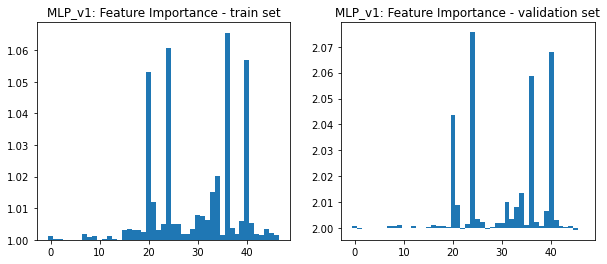

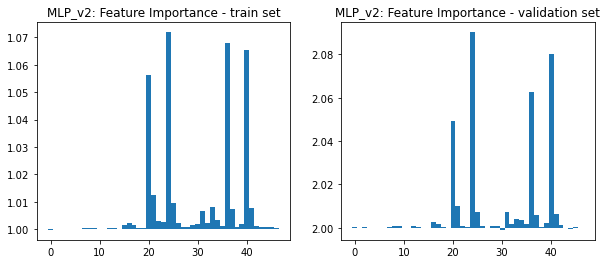

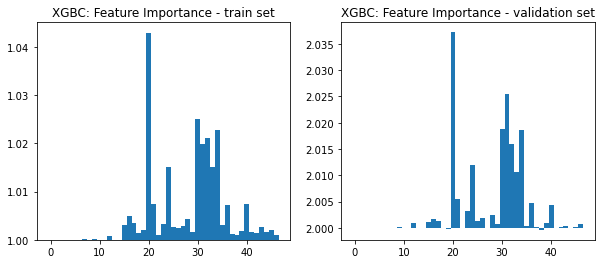

In [63]:
plot_feature_importance(fpi_train_v1['importances_mean'], fpi_valid_v1['importances_mean'], dataset=['train','validation'], model='MLP_v1')
plot_feature_importance(fpi_train_v2['importances_mean'], fpi_valid_v2['importances_mean'], dataset=['train','validation'], model='MLP_v2')
plot_feature_importance(fpi_train_xgbc['importances_mean'], fpi_valid_xgbc['importances_mean'], dataset=['train','validation'], model='XGBC')

The most important features for MLPv1 and MLPv1 are similar for MLPv1 and MLPv1, however, they are very different for the XGBC model.

In [65]:
feat_importances = pd.DataFrame.from_dict({'features':features_fin,
             'MLP_train_v1':fpi_train_v1['importances_mean'],
             'MLP_valid_v1':fpi_valid_v1['importances_mean'],
             'MLP_train_v2':fpi_train_v2['importances_mean'],
             'MLP_valid_v2':fpi_valid_v2['importances_mean'],
             'xgbc_train':fpi_train_xgbc['importances_mean'],
             'xgbc_valid':fpi_valid_xgbc['importances_mean'],
                                          }).sort_values(['xgbc_valid'],ascending=False)

In [66]:
print(feat_importances[feat_importances['xgbc_valid']>=0.001].shape)
feat_importances[feat_importances['MLP_valid_v1']>=0.001]

(17, 7)


,features,MLP_train_v1,MLP_valid_v1,MLP_train_v2,MLP_valid_v2,xgbc_train,xgbc_valid
20,current_balance,0.053192,0.043707,0.056114,0.049425,0.042947,0.037208
31,previous_month_end_balance_pct,0.007439,0.010020,0.006547,0.007286,0.019966,0.025395
30,current_month_balance_pct,0.007715,0.001932,0.001820,-0.001037,0.025129,0.018759
34,average_monthly_balance_prevQ2_pct,0.020253,0.013521,0.003332,0.003530,0.022786,0.018604
32,previous_month_balance_pct,0.006350,0.003351,0.002200,0.001860,0.021091,0.015965
24,average_monthly_balance_prevQ,0.060671,0.075595,0.071838,0.090212,0.015003,0.011929
33,average_monthly_balance_prevQ_pct,0.015232,0.008310,0.007932,0.004183,0.015050,0.010647
21,current_month_balance,0.011915,0.009082,0.012419,0.009947,0.007396,0.005440
36,current_balance_balpers,0.065527,0.058804,0.067979,0.062422,0.007295,0.004734
40,average_monthly_balance_prevQ_balpers,0.056958,0.067904,0.065342,0.080248,0.007350,0.004283


The most important features are balance features, and most of them are engineered features (the percent changes of consecutive periods). Current balance, or current balance per household person has the highest importance value in all 3 best models, signifying this feature is the most important one for predicting customer churn.

In [67]:
print(feat_importances[feat_importances['xgbc_valid']<=0.00001].shape)
feat_importances[feat_importances['xgbc_valid']<=0.00001]

(17, 7)


,features,MLP_train_v1,MLP_valid_v1,MLP_train_v2,MLP_valid_v2,xgbc_train,xgbc_valid
6,x0_6.0_dependents,0.000014,0.000014,0.000007,-4.659068e-07,0.000000,0.000000
2,x0_2.0_dependents,0.000217,0.000127,0.000169,8.113434e-05,0.000000,0.000000
3,x0_3.0_dependents,0.000072,0.000054,0.000072,1.464278e-06,0.000000,0.000000
4,x0_4.0_dependents,0.000011,-0.000138,0.000008,-2.196418e-06,0.000000,0.000000
0,x0_0.0_dependents,0.001083,0.000802,-0.000267,8.559373e-05,0.000000,0.000000
5,x0_5.0_dependents,0.000027,-0.000008,0.000002,-8.386322e-06,0.000000,0.000000
8,x0_Male,0.000968,0.000879,0.000427,7.717413e-04,0.000000,0.000000
10,x1_Chef,0.000020,0.000026,0.000009,1.970120e-05,0.000000,0.000000
11,x1_Doctor,0.000146,0.000032,0.000034,2.995115e-06,0.000000,0.000000
13,x1_Lawyer,0.000157,0.000147,0.000262,1.524181e-04,0.000000,0.000000


The above features have zero or negative importance to the model for th XGBoosting model. This means that these features do not contribute to the prediction of the churn and can be removed from the model. These features are mainly from one-hot-encoded columns of "dependents" and "occupation". The following numerical features Previous month debit, current month debit per household person, branch code, and days since last transaction also do not contribute to the model prediction and can be removed.

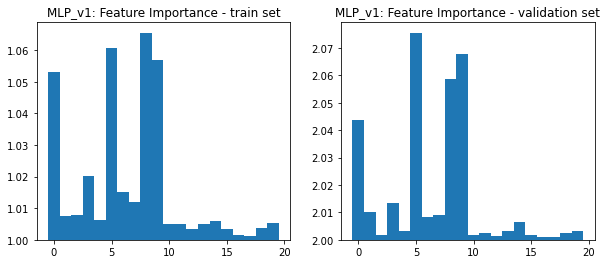

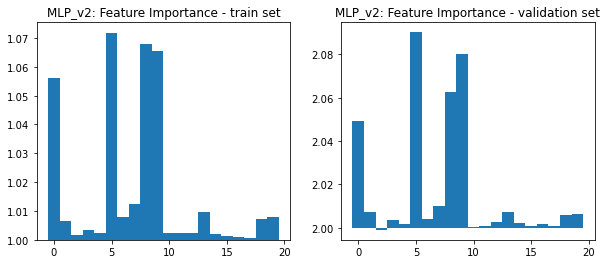

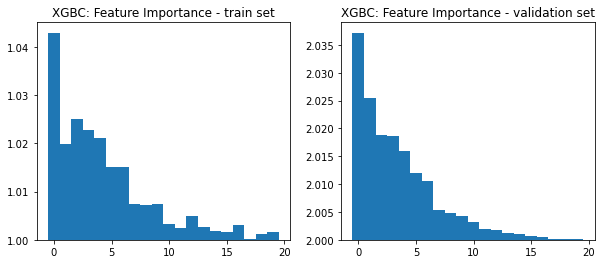

In [68]:
idx = feat_importances[feat_importances['MLP_valid_v1']>=0.001].index
plot_feature_importance(fpi_train_v1['importances_mean'][idx], fpi_valid_v1['importances_mean'][idx], dataset=['train','validation'], model='MLP_v1')
plot_feature_importance(fpi_train_v2['importances_mean'][idx], fpi_valid_v2['importances_mean'][idx], dataset=['train','validation'], model='MLP_v2')
plot_feature_importance(fpi_train_xgbc['importances_mean'][idx], fpi_valid_xgbc['importances_mean'][idx], dataset=['train','validation'], model='XGBC')

The above dataframe and bar plot shows the 17 most important features in predicting the churn. We could use these features to further train the model and evaluate the effects of feature selection on performace of the candidate models. <br>

They also showes that the most importance feature are about the same for the 2 MLP models, however, they are very different for the XGBoosting model. The main reason might come from the fact that MLP models cannot deal with colinearity existing in the data and XGBC model can. <br>

## Persist the best model

In [297]:
# Best model:
print(f'MLP v1 - Best prediction score v1: {round(clf_nn_v1_roc_auc,4)}')
clf_randsearchcv_v1.best_params_

MLP v1 - Best prediction score v1: 0.8371


{'classifier': MLPClassifier(alpha=0.47857874420504615, learning_rate='invscaling',
               random_state=15611),
 'classifier__activation': 'relu',
 'classifier__alpha': 0.47857874420504615,
 'classifier__learning_rate': 'invscaling',
 'classifier__solver': 'adam'}

In [255]:
joblib.dump(clf_randsearchcv_v1.best_estimator_, 'Best churn classifier.joblib')

['Best churn classifier.joblib']

## Predict on new dataset

In [268]:
submit = pd.read_csv('./data/visathon_test_data.csv')
X_submit = submit.drop(target,axis=1).copy()

In [269]:
X_submit_transformed = pipeline_data.transform(X_submit)
X_submit_transformed.shape

(4413, 47)

In [288]:
def predict_and_submit(model,X,filename='submission'):
    pred_submit = model.predict(X)
    submission = submit[['customer_id','churn']].copy()
    submission['churn'] = pred_submit
    submission['churn'] = submission['churn'].map({'Yes':1,'No':0})
    submission.to_csv(filename+'.csv',index=False)
    
predict_and_submit(clf_randsearchcv_v1.best_estimator_,X_submit_transformed,filename='mlp_submission')

The Kaggle competition leaderboard showed that the prediction score was 0.67416, which is much lower than the score on the validation set and was unexpected. 

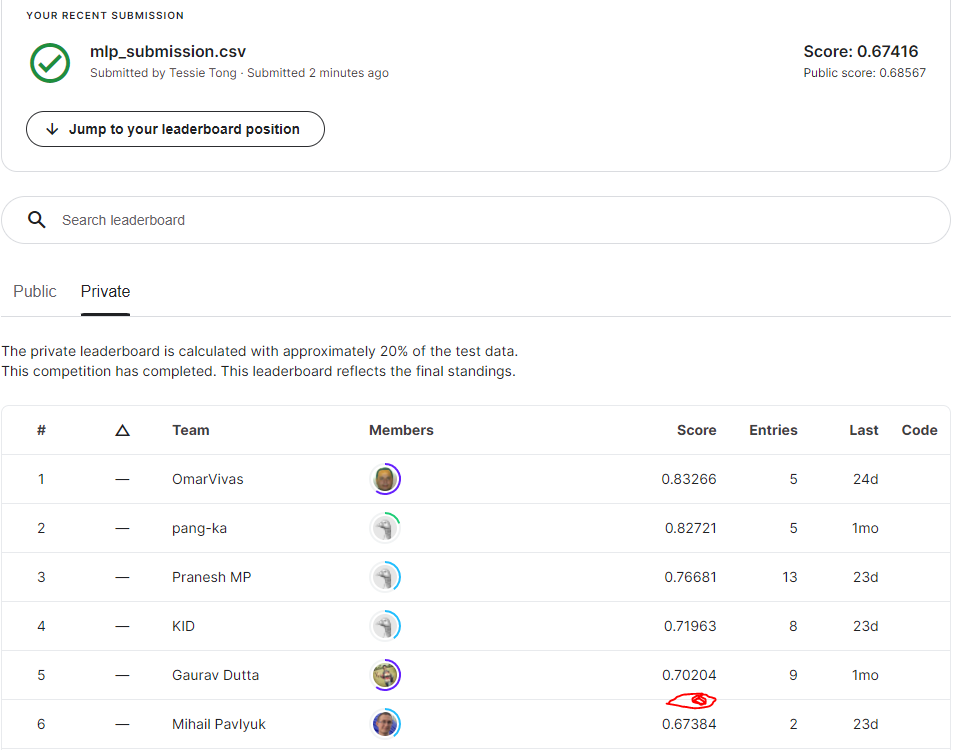

The reasons might lie on several aspects:<br>

    1) The test data set is very different from the train and validation sets. For example, the test set was not from the same period of time and churn pattern has evolved since. <br>
    2) our best model is overfitting. But this is not what was revealed in the learning curve.<br>
    3) model is underfitting. This is in agreement with the learning curve. We need to further tune our model, or engineer more features.<br>
    4) In this exercise, we did not remove the features that are correlated. Further tests are need to experiement feature selection.<br>
    
Due to time and resource constraints, we will leave this as one of our future objectives.

## Summary
The work on this project is divided into several parts, each presented in a separate notebook. We started by <br>
**Part 1)** loading the data and performing exporatory data analysis, <br>
**Part 2)** moved into building baseline models of dozens of classfication models and selecting best candidate models for hyperparameter tuning. In the second part of the work, we engineered features based one our understanding of the dataset and domain knowledge and built data pipelines to streamline data preprocessing and ensure the same process for train and validation data sets. <br>
**Part 3)** We then trained over a dozen of classification models and tuned several promising ones. We then looked at another aspect of model performance, i.e., weather the model is underfitting, overfitting or just perfect. Finally we looked at the importance of each features by computing the permutation importance of each feature. 

Below list captures the main steps of this work:

1) Perform Exploratory data analysis
2) Build and evaluate baseline models without feature engineering
3) Perform Feature engineering and create data pipelines
4) Compare more than dozens of classifiers on a performance metric
5) Perform hyperparameter tuning on a few best canadidate models
6) Evaluate the best candidate models on the validation set
7) Analyze feature importance
8) Persist the best models for deployment or further tuning

## **Conclusions**
1) **The best model is multi-layer perceptron (MLPClassifier)** from scikit-learn's neural network module, with the **prediction accurace of 0.837**. 
2) The **most influencial features** are: <br>
    -- average_monthly_balance_prevQ <br>
    -- average_monthly_balance_prevQ per person in the household <br>
    -- current_balance per person in the household <br>
    -- current_balance <br>
3) Most of the engineered features are among the top 20 most influencial features.
4) The best model is able to predict customer churn with 83.7% accuracy.
5) The best model is somewhat ***underfitting***.
6) The **feature engineering improved the prediction accuracy from 72% to 83%**.
7) Although our prediction score is lower than what we have expected, we are placed in the ***6th place on the final learderboard***. 

## **What we learned**
We have learned a lot from this exercise of machine learning project: <br>

1) Importance of planning a machine learning project by outlining the objectives and steps to accomplish them.
2) The Best approach to building ML model - an iterative approach. It is better to take a small step and varify the results than spending long time to get a complex model then later finding the solution not working.
3) The art of trade-off between the best and better vs expensive and affordable.
4) Additional knowledge and experience from this end-to-end ML project.
5) The importance of collaboratiob and as a team player.
6) Importance of persisting intermediate results. 

## **Future work**
We performed the feature importance analysis on the best model, and found out the most influencial features. To futher improve model prediction accuracy, our future work is therefore including, but not limiting to: <br>

1) Select the top n features to train and tune the model.
2) Interpret the model results to the extent possible.
3) Further improve predictive power by using more complex algorithms, such as deep learning with TensorFlow's advanced neural networks, since the best MLPclassifier has only 83.7% accuracy, and is underfitting. 
4) Improve competition score by frequently submitting prediction result so that we are going in the right direction. In the real world, we can also test our model using unseen new data.

This concludes our work.